# OpenRA analysis

We perform exploratory analysis of the dataset provided. See [`notes.md`][1] for notes. 

[1]: notes.md

Before we get started, let's import some packages so we have them available for the rest of the notebook.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%load_ext watermark

%autoreload 1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns
from IPython.display import Image

# Some utils code, which is autoreloaded whenever code from it is called.
%aimport utils

plt.style.use('ggplot')

sqlite_url = 'sqlite:///openra-20170606.db'

%watermark

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.
09/06/2017 12:56:40

CPython 3.6.1
IPython 6.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


Now we think about what we want to know. First we start by re-creating the previous work done.

## Re-creating the previous work

To recap, the [previous analysis][1] investigated these things:

* OS split (windows/mac/linux)
* Cumulative number of players
* Language settings
* Most popular mod
* Most popular mod by language setting
* Most popular map
* Match length

[1]: http://www.openra.net/news/2017-01-stats-post/

### OS split

In [2]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-downloads-vs-users.png'))

In [3]:
# Select distinct system ids to ensure unique systems
sysinfo_platforms = pd.read_sql(
    '''
    select platform, count(distinct system_id) as n_users
    from sysinfo
    where platform is not null
    group by platform
    ''',
    'sqlite:///openra-20170606.db').set_index('platform')

# sort into the same order as above
sysinfo_platforms = sysinfo_platforms.loc[['Windows', 'Linux', 'OSX']]
sysinfo_platforms

,n_users
platform,
Windows,87254
Linux,16921
OSX,9551


We see from the raw numbers that since 2017-01 when the blog post was written (which may or may not be when the analysis was performed), the user count has gone up massively. Remember we are comparing to the orange bars in the plot above, and as such all platforms have increased by between 4x and 6x.

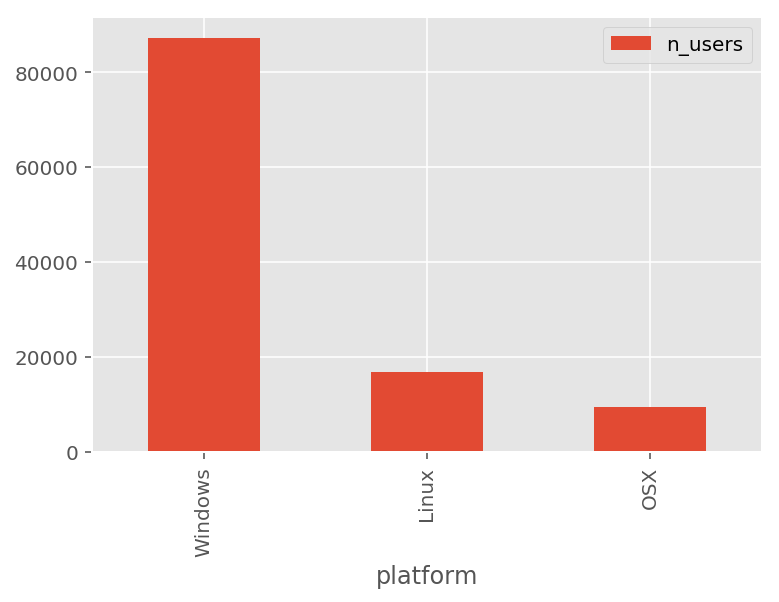

In [4]:
sysinfo_platforms.plot.bar()

In [5]:
# Look at approximate increase in users since 2017-01
sysinfo_platforms['previous_n_users'] = [15000, 4000, 2000]
sysinfo_platforms['approx_increase'] = sysinfo_platforms['n_users'] / sysinfo_platforms['previous_n_users']
sysinfo_platforms[['approx_increase']]

,approx_increase
platform,
Windows,5.816933
Linux,4.230250
OSX,4.775500


What we don't know however is how many of the people who were not submitting system info have enabled submitting system info since the blog post so this is all a little speculative. We also assume a subset of the new dataset were in the previous subset, and as such the increase in players is an upper limit.

We still find the dominant platform is Windows.

In [6]:
sysinfo_platforms['platform_increase'] = sysinfo_platforms['n_users'] / sysinfo_platforms['n_users']['OSX']
sysinfo_platforms[['platform_increase']]

,platform_increase
platform,
Windows,9.135588
Linux,1.771647
OSX,1.000000


We find that there are 9 times as many Windows users as mac users, and nearly twice as many linux players as mac users. This makes sense, as the linux retro gaming community is quite strong. 

### Cumulative number of players

We can compute the cumulative number of players for the duration listed, by joining the `finished` table with the `started` table and computing the cumulative sum of the number of players as a function of date of the game.

In [7]:
cumulative_nplayers = pd.read_sql(
    '''
    SELECT finished.started as start_time, started.players
    FROM finished
    LEFT JOIN started using (game_id)
    WHERE players > 0
    ''', 'sqlite:///openra-20170606.db')
cumulative_nplayers = cumulative_nplayers.set_index(pd.to_datetime(cumulative_nplayers['start_time']))
cumulative_nplayers.head()

,start_time,players
start_time,,
2014-09-24 06:41:19,2014-09-24 06:41:19,1
2014-09-24 07:32:39,2014-09-24 07:32:39,3
2014-09-24 07:53:55,2014-09-24 07:53:55,4
2014-09-24 08:01:57,2014-09-24 08:01:57,4
2014-09-24 08:14:30,2014-09-24 08:14:30,1


In [8]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-last-launches.png'))

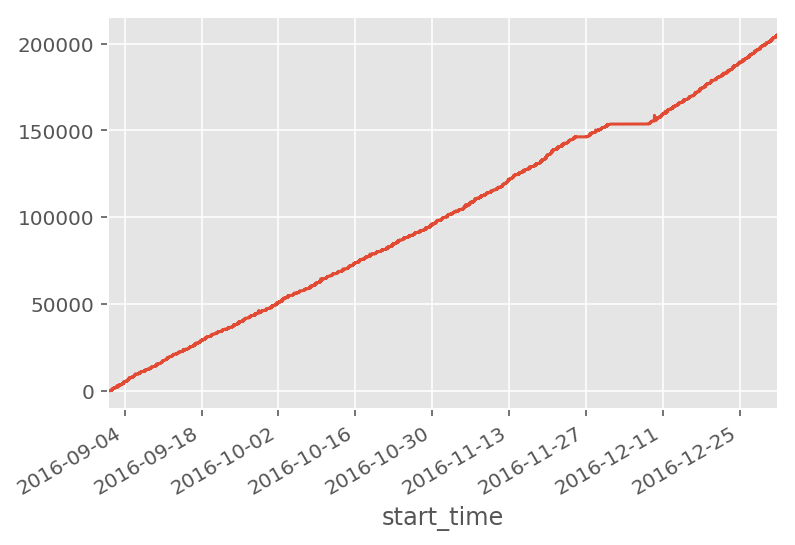

In [9]:
cumulative_nplayers['players'][(cumulative_nplayers.index > '2016-09-01') & (cumulative_nplayers.index < '2017-01-01')].cumsum().plot()

Come back to this later...

### Language settings

In [10]:
language_breakdown = pd.read_sql(
    '''
    SELECT lang, COUNT(lang) AS n_lang
    FROM sysinfo
    WHERE lang IS NOT NULL
    GROUP BY lang
    ORDER BY n_lang DESC
    LIMIT 20
    ''', sqlite_url)
language_breakdown = language_breakdown.set_index(language_breakdown['lang'])
language_breakdown.head()

,lang,n_lang
lang,,
en,en,57891
de,de,26205
cs,cs,4474
ru,ru,3912
nl,nl,3625


In [11]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-languages.png'))

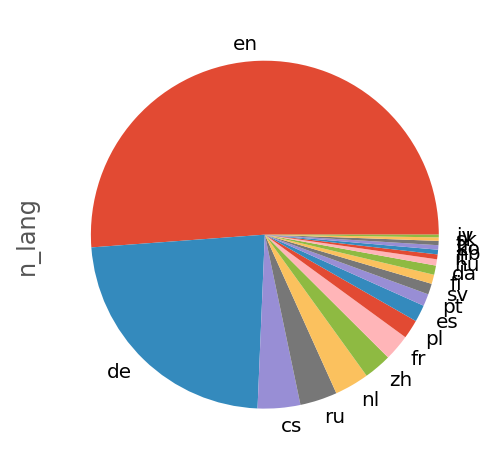

In [12]:
ax = language_breakdown.n_lang.plot.pie()
ax.set_aspect('equal')

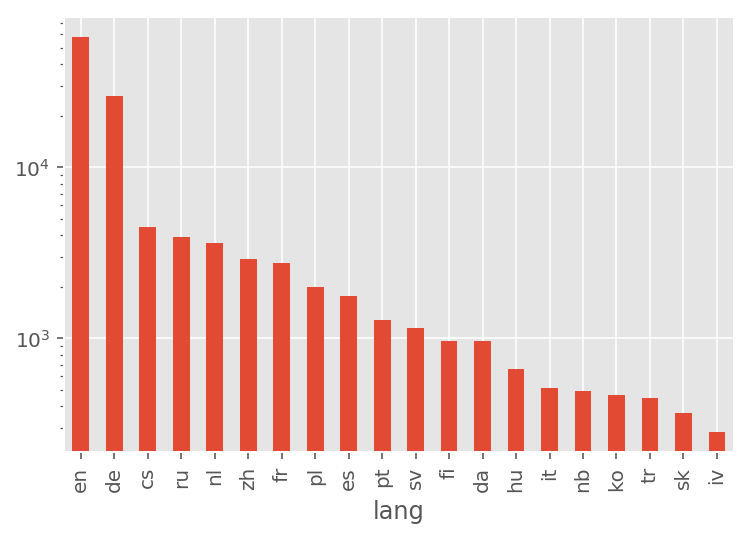

In [13]:
language_breakdown.n_lang.plot.bar(logy=True)

It seems like Czech and Russian players are higher on the list than they used to be.

### Mod breakdown by language

In [15]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-mod-popularity-per-language.png'))

In [154]:
mod_by_lang = pd.read_sql(
    '''
    SELECT DISTINCT system_id, lang, mod AS rawmod
    FROM sysinfo
    WHERE system_id IS NOT NULL
    AND rawmod IN ('d2k', 'cnc', 'ra')
    AND lang in (
        SELECT lang
        FROM sysinfo
        GROUP BY lang
        ORDER BY COUNT(lang) DESC
        LIMIT 20
    )
    ''', sqlite_url
)
mod_by_lang['lang'] = pd.Categorical(mod_by_lang['lang'])
mod_by_lang['rawmod'] = pd.Categorical(mod_by_lang['rawmod'])
mod_by_lang.head()

,system_id,lang,rawmod
0,00011aff-e232-4033-852a-b2f026fa62a8,en,ra
1,00012da9-b1d4-4b70-af89-562f53046e3e,de,ra
2,00015036-c5ff-45e4-9455-993ad99174fd,de,d2k
3,0001f37d-ff3a-4fcd-a6d9-e7763be9e242,en,ra
4,0002b107-c3e2-4737-9806-6c87184f38f1,en,ra


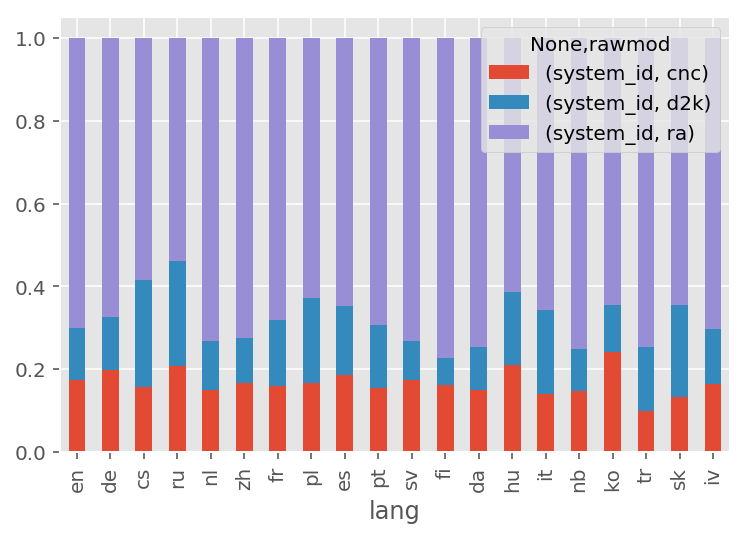

In [162]:
mod_fractions = mod_by_lang.pivot_table(index='lang', columns='rawmod', aggfunc='count')
mod_fractions = mod_fractions.div(mod_fractions.sum(1), axis=0)
mod_fractions.loc[language_breakdown['lang']].plot.bar(stacked=True)

Ignore the fact that the bars are upside down, and the legend is confusing, but we see the equivalent plot to the one shown above. We see `ra` is most popular in the Netherlands, Finland, Denmark, and least popular in Russia, Hungary and Korea.

###  Map breakdown

Now we break down the favourite map rotation. To get the names, we first need to get the hash -> map name mapping. We must query the web server for this. To save ourselves from spamming the server, we first get the top 40 map hashes.

In [203]:
map_breakdown = pd.read_sql(
    '''
    SELECT map, played_counter
    FROM map_stats
    ORDER BY played_counter DESC
    LIMIT 100
    ''', sqlite_url)
map_breakdown.head()

,map,played_counter
0,35d0a9c369173dbd5a4c1df9693e1fe96364ab81,5395
1,9a0be9fc201c0fe99407e2a2962b66629fb7b2cc,4689
2,5bea6c8d4522a4881f75af5171f341cf4197b25f,4413
3,c249e540adfcede58e344ee8e41601a4ef204051,3954
4,a41a87f70d9ba0bda45ba2dd126ce9b76a42a2ed,3853


In [205]:
# This function caches the results on disk to save multiple queries
map_hash_to_name_mapping = utils.build_map_hash_to_name_mapping(map_breakdown['map'].values)

In [206]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-top-ten-mp-maps.png'))

In [222]:
map_breakdown['map_name'] = map_breakdown['map'].apply(lambda h: map_hash_to_name_mapping[h])
map_breakdown = map_breakdown.loc[
    map_breakdown['map_name'].apply(lambda name: name is not None)
]

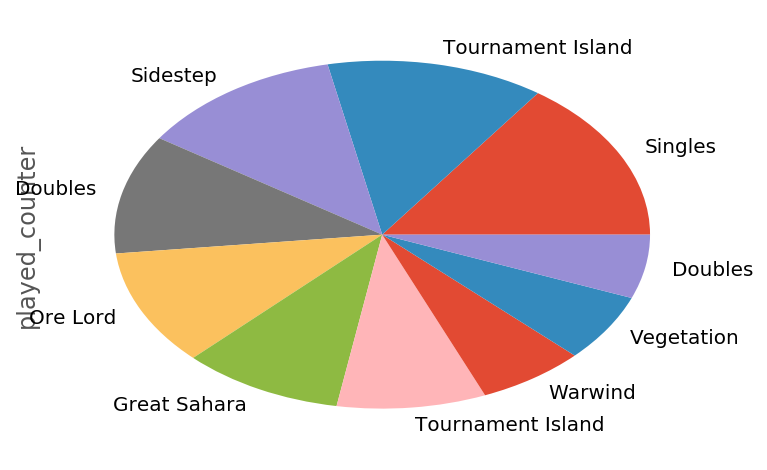

In [221]:
map_breakdown.set_index('map_name')['played_counter'][:10].plot.pie()

We see that `Singles` has overtaken `Tournament Island` and `Doubles` in popularity. In fact `Doubles` has dropped down the list.

In [224]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-most-popular-maps.png'))

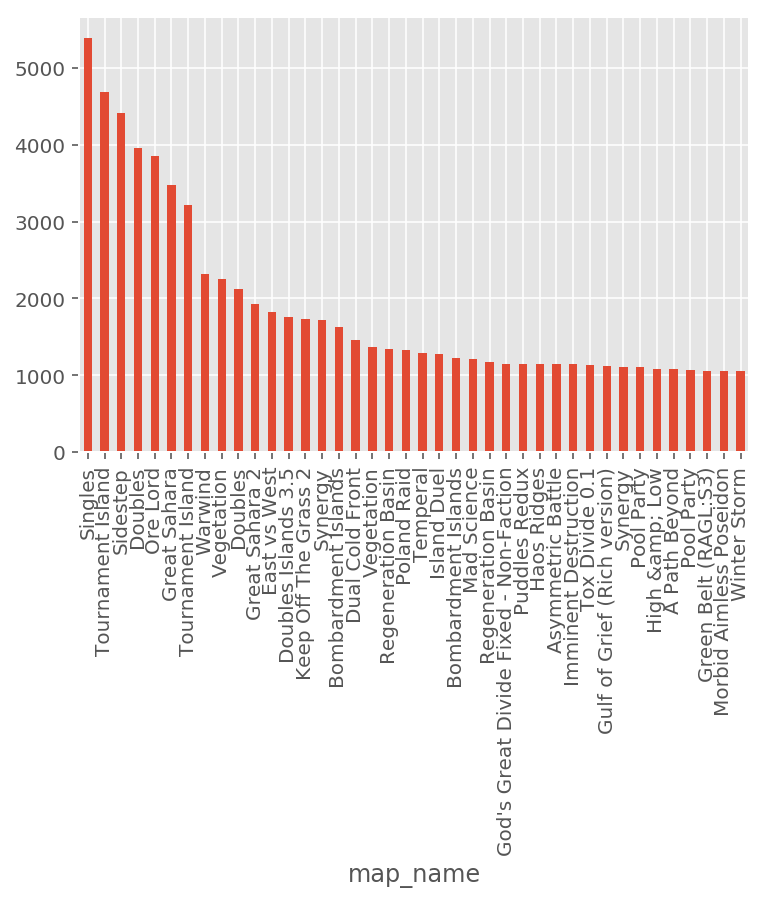

In [223]:
map_breakdown.set_index('map_name')['played_counter'][:40].plot.bar()

###  Average match length

In [249]:
match_length = pd.read_sql(
    '''
    SELECT game_mod, AVG(strftime('%s', finished) - strftime('%s', started)) AS mean_duration_s
    FROM finished
    WHERE game_mod IN ('ra', 'cnc', 'd2k')
    GROUP BY game_mod
    ''', sqlite_url)
match_length = match_length.append(
    pd.DataFrame([['ALL', match_length['mean_duration_s'].mean()]], columns=['game_mod', 'mean_duration_s']),
    ignore_index=True
)
match_length

,game_mod,mean_duration_s
0,cnc,1104.783452
1,d2k,1428.583902
2,ra,1396.771977
3,ALL,1310.046444


In [225]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-avg-match-length.png'))

''

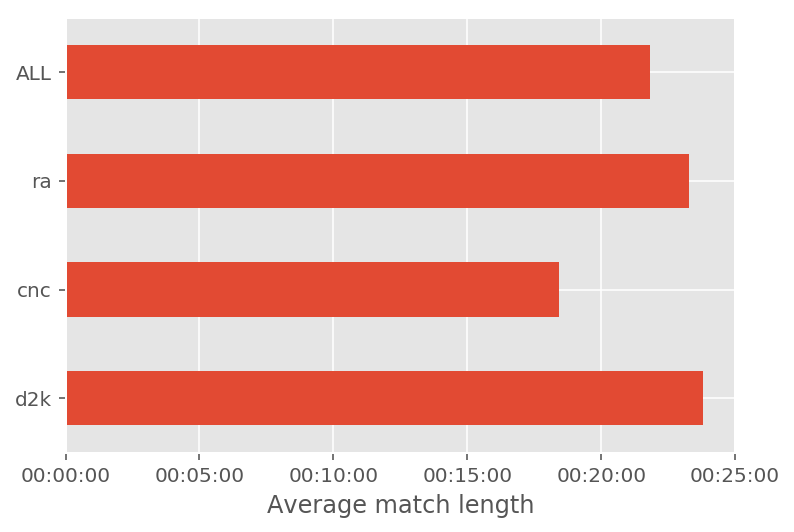

In [274]:
ax = match_length.set_index('game_mod')['mean_duration_s'].loc[['d2k', 'cnc', 'ra', 'ALL']].plot.barh()
ticks = np.arange(0, ax.get_xlim()[1], 300)
ticklabels = [str(pd.to_timedelta(t, unit='s')).split()[-1] for t in ticks]
ax.set(
    xticks=ticks,
    xticklabels=ticklabels,
    xlabel='Average match length',
    ylabel='',
)
;